import de bibliothèques ! :

In [1]:
import numpy as np
import pandas as pd

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import random
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import seaborn as sns


In [2]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Par la suite, il faut développer les étapes suivantes :

– Charger les images.

– Penser à redimensionner les images selon le modèle VGG16.

– Appliquer la préparation des données nécessaire pour le modèle VGG16.

– Splitter les données en données d’apprentissage, validation et test.

– Visualiser les images de la classe Avec_Masque et Sans_Masque.

affichage d'une image :

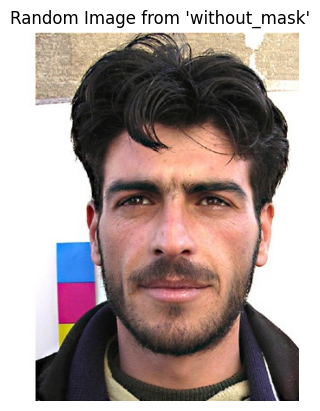

In [3]:
# Define the path to your 'Mask_Data' folder
path_mask_data = '/content/drive/MyDrive/Brief_masques/Mask_Data'

# Create a list of subfolders ('with_mask' and 'without_mask')
subfolders = ['with_mask', 'without_mask']

# Choose a random subfolder
random_subfolder = random.choice(subfolders)

# Get a list of all image files in the chosen subfolder
image_files = os.listdir(os.path.join(path_mask_data, random_subfolder))

# Choose a random image file from the selected subfolder
random_image_file = random.choice(image_files)

# Construct the full path to the random image
random_image_path = os.path.join(path_mask_data, random_subfolder, random_image_file)

# Load and display the random image
image = imread(random_image_path)
plt.imshow(image)
plt.title(f"Random Image from '{random_subfolder}'")
plt.axis('off')
plt.show()

Charger les images

In [4]:
path_mask = "/content/drive/MyDrive/Brief_masques/Mask_Data/with_mask"
path_no_mask = "/content/drive/MyDrive/Brief_masques/Mask_Data/without_mask"

# Initialize empty lists to store file paths and labels
images = []
labels = []

# Iterate through the 'with_mask' directory and append file paths and labels
for filename in os.listdir(path_mask):
  images.append(os.path.join(path_mask, filename))
  labels.append('with_mask')

# Iterate through the 'without_mask' directory and append file paths and labels
for filename in os.listdir(path_no_mask):
  images.append(os.path.join(path_no_mask, filename))
  labels.append('without_mask')

# Nouvelle section

Splitter les données en données d’apprentissage, validation et test

In [5]:
# Split data into training, testing and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, random_state=25)



Redimensionner les images selon le modèle VGG16 (définit les paramètres)

In [6]:
# Define image size
IMSIZE = (224, 224)

Appliquer la préparation des données nécessaire pour le modèle VGG16

In [7]:
# Convert training, validation and testing data in a DataFrame
train_df = pd.DataFrame({'images': X_train, 'label': y_train})
test_df = pd.DataFrame({'images': X_test, 'label': y_test})
validation_df = pd.DataFrame({'images': X_validation, 'label': y_validation})

batch_size = 32


image_gen = ImageDataGenerator(
  rescale=1 / 255.0,
  rotation_range=20,
  zoom_range=0.05,
  width_shift_range=0.05,
  height_shift_range=0.05,
  shear_range=0.05,
  horizontal_flip=True,
  fill_mode="nearest",
  validation_split=0.20)


# Create generators
train_generator = image_gen.flow_from_dataframe(
  dataframe=train_df,
  x_col='images',
  y_col='label',
  target_size=IMSIZE,
  shuffle=True,
  batch_size=batch_size,
  )

test_generator = image_gen.flow_from_dataframe(
  dataframe=test_df,
  x_col='images',
  y_col='label',
  target_size=IMSIZE,
  shuffle=True,
  batch_size=batch_size,
  )

validation_generator = image_gen.flow_from_dataframe(
dataframe=validation_df,
x_col='images',
y_col='label',
target_size=IMSIZE,
shuffle=True,
batch_size=batch_size,
)


Found 904 validated image filenames belonging to 2 classes.
Found 302 validated image filenames belonging to 2 classes.
Found 302 validated image filenames belonging to 2 classes.


Visualiser les images de la classe Avec_Masque et Sans_Masque

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


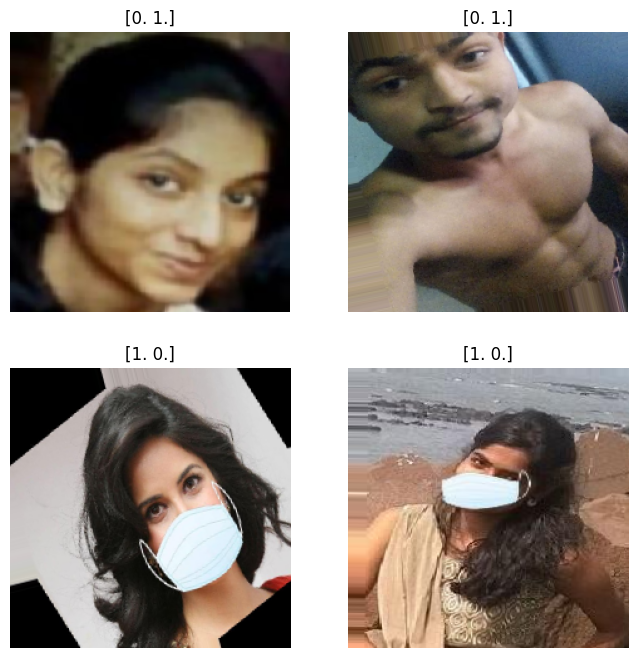

In [8]:
# Display 4 images from the training set
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten() # Flatten the 2D array of axes in 1D


for i in range(4):
  image, label = train_generator.next()
  ax[i].imshow(image[0])
  ax[i].set_title(label[0])
  ax[i].axis('off')


plt.show()


Création du modèle :

In [9]:
NBCLASSES = 2


def create_model():
  vgg = VGG16(input_shape=(224,224,3), weights="imagenet", include_top= False)
  for layer in vgg.layers:
    layer.trainable = False

    out = vgg.output

    x = Flatten()(out)
    x = Dense(NBCLASSES, activation="softmax")(x)

    model = Model(inputs=vgg.input,outputs=x)

    model.compile(loss="binary_crossentropy",
                  optimizer = "adam",
                  metrics = ["accuracy"])

    model.summary()

    return model

mymodel = create_model()


58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

Entraînement :

In [10]:
#train_data = np.array(train_generator)


epochs = 10
Callbacks = ModelCheckpoint(
    "/content/drive/MyDrive/Brief_mask/best_model",
    monitor = 'val_accuracy',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

history = mymodel.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=epochs,
    callbacks=[Callbacks]
)


Epoch 1/10
29/29 [==============================] - 361s 12s/step - loss: 0.8435 - accuracy: 0.5265 - val_loss: 0.7022 - val_accuracy: 0.5000
Epoch 2/10
29/29 [==============================] - 40s 1s/step - loss: 0.5407 - accuracy: 0.7113 - val_loss: 0.2004 - val_accuracy: 0.9437
Epoch 3/10
29/29 [==============================] - 29s 990ms/step - loss: 0.1736 - accuracy: 0.9458 - val_loss: 0.1361 - val_accuracy: 0.9669
Epoch 4/10
29/29 [==============================] - 28s 957ms/step - loss: 0.1180 - accuracy: 0.9580 - val_loss: 0.0744 - val_accuracy: 0.9735
Epoch 5/10
29/29 [==============================] - 27s 907ms/step - loss: 0.0979 - accuracy: 0.9679 - val_loss: 0.0998 - val_accuracy: 0.9636
Epoch 6/10
29/29 [==============================] - 29s 1s/step - loss: 0.1035 - accuracy: 0.9701 - val_loss: 0.1071 - val_accuracy: 0.9669
Epoch 7/10
29/29 [==============================] - 25s 871ms/step - loss: 0.1115 - accuracy: 0.9657 - val_loss: 0.1202 - val_accuracy: 0.9603
Epoch 

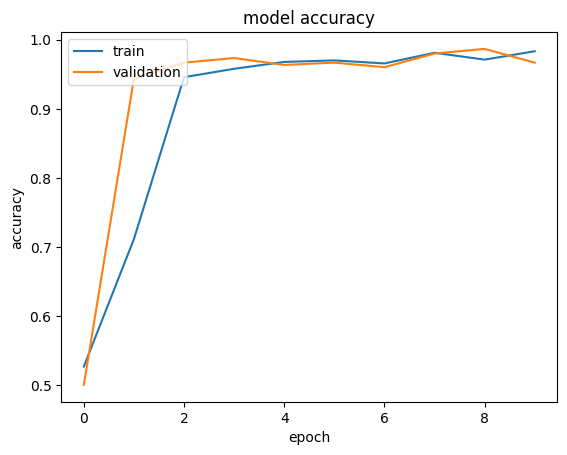

In [11]:
# Display accuracy and from train and validation dataset
plt.plot(mymodel.history.history['accuracy'])
plt.plot(mymodel.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

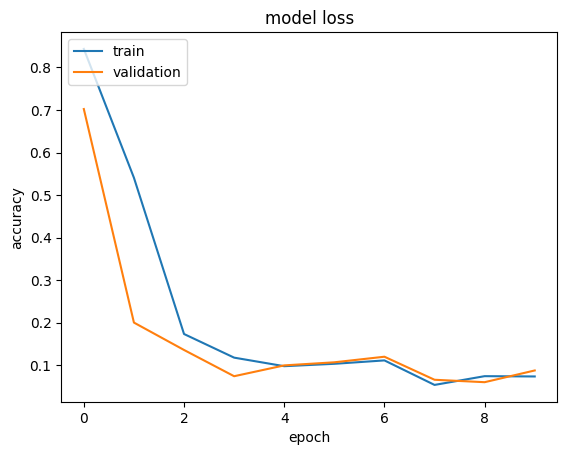

In [12]:
# Display loss from train and validation dataset
plt.plot(mymodel.history.history['loss'])
plt.plot(mymodel.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



évaluation rapide :

In [13]:
y_pred = mymodel.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = validation_generator.classes
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)
print(confusion_mtx)

10/10 [==============================] - 7s 635ms/step
[[79 72]
 [64 87]]


In [14]:
score = mymodel.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 88s 10s/step - loss: 0.1374 - accuracy: 0.9536
Test loss: 0.13736771047115326
Test accuracy: 0.9536423683166504
